# Library

In [1]:
# Library
import os
import time
import numpy as np
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
from tqdm import tqdm
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
# torch
import torch
from torch import nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader
from torch.optim.lr_scheduler import MultiStepLR
# rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
# catcvae
from catcvae.setup import ModelArgumentParser
from catcvae.molgraph import atom_encoder_m, bond_encoder_m, atom_decoder_m, bond_decoder_m, max_atom_number, matrix_size, matrix2mol
from catcvae.dataset import getDatasetFromFile, getDatasetObject, getDatasetSplittingFinetune, getDataLoader, getDataObject
from catcvae.condition import getConditionDim, getOneHotCondition
from catcvae.classweight import getClassWeight
from catcvae.loss import VAELoss, Annealer, recon_loss_fn, cosine_similarity, ALLLoss
from catcvae.ae import CVAE
from catcvae.ae import latent_space_quality, sample_latent_space
from catcvae.training import save_model, save_loss, save_report, save_model_latest
from catcvae.prediction import NN
from catcvae.latent import embed, save_latent


No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
2025-05-14 16:43:25.312004: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (/opt/anaconda3/envs/multimolrep38/lib/python3.8/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading some Jax models, missing a dependency. No module named 'jax'


# Arguments

In [2]:
# settting
parser = ModelArgumentParser()
args = parser.setArgument('''
--file niwa_lewis_246_ligand_2
--seed 0
--AE_type CVAE
--emb_dim 256
--emb_cond_dim 256
--embedding_type None
--encoder_type MATRIX
--decoder_type GRAPH
--num_layer 3
--dropout_ratio 0.3 
--gnn_type gat
--readout mean
--beta 0.001 
--batch_size 8
--epochs 800 
--lr 0.001 
--decay 0.00005
--class_weight enabled
--teacher_forcing 
--pretrained_file niwa_lewis_246_ligand_2
--pretrained_time 3_20250412_171617_3671575_C
'''.split())

args

args: Namespace(AE_loss='CE', AE_type='CVAE', JK='last', alpha=1, annealing=True, annealing_shape='cosine', annealing_slope_length=100, augmentation=0, batch_size=8, beta=0.001, class_weight='enabled', cond_dim=8, condition_dict={'mw_ligand': {'type': 'continuous', 'list': [100, 200, 300, 400, 500, 1000]}}, condition_extra=None, correction='enabled', decay=5e-05, decoder_type='GRAPH', decoding_setting={'type': 'GRAPH', 'emb_dim': 256, 'emb_cond_dim': 256, 'cond_dim': 8, 'max_atom_number': 100, 'len_atom_type': 68, 'len_bond_type': 6, 'matrix_size': 66900, 'num_layer': 3, 'dropout_ratio': 0.3, 'teacher_forcing': True, 'guide_tensor': False}, detach_target=True, device=device(type='cpu'), dropout_ratio=0.3, emb_cond_dim=256, emb_dim=256, embedding_setting={'type': 'None', 'num_layer': 3, 'emb_dim': 256, 'emb_cond_dim': 256, 'JK': 'last', 'readout': 'mean', 'dropout_ratio': 0.3, 'gnn_type': 'gat'}, embedding_type='None', encoder_type='MATRIX', encoding_setting={'type': 'MATRIX', 'emb_dim'

Namespace(AE_loss='CE', AE_type='CVAE', JK='last', alpha=1, annealing=True, annealing_shape='cosine', annealing_slope_length=100, augmentation=0, batch_size=8, beta=0.001, class_weight='enabled', cond_dim=8, condition_dict={'mw_ligand': {'type': 'continuous', 'list': [100, 200, 300, 400, 500, 1000]}}, condition_extra=None, correction='enabled', decay=5e-05, decoder_type='GRAPH', decoding_setting={'type': 'GRAPH', 'emb_dim': 256, 'emb_cond_dim': 256, 'cond_dim': 8, 'max_atom_number': 100, 'len_atom_type': 68, 'len_bond_type': 6, 'matrix_size': 66900, 'num_layer': 3, 'dropout_ratio': 0.3, 'teacher_forcing': True, 'guide_tensor': False}, detach_target=True, device=device(type='cpu'), dropout_ratio=0.3, emb_cond_dim=256, emb_dim=256, embedding_setting={'type': 'None', 'num_layer': 3, 'emb_dim': 256, 'emb_cond_dim': 256, 'JK': 'last', 'readout': 'mean', 'dropout_ratio': 0.3, 'gnn_type': 'gat'}, embedding_type='None', encoder_type='MATRIX', encoding_setting={'type': 'MATRIX', 'emb_dim': 256,

# Dataset

In [3]:
# finetune dataset
path_train = args.folder_path+'/datasets_dobj_train_'+str(args.seed)+'.pkl'
# if os.path.exists(path_train):
#     # get datasets splitting
#     datasets_dobj_train, datasets_dobj_val, datasets_dobj_test = getDatasetSplittingFinetune(args, datasets_df=None, datasets_dobj=None, augmentation=args.augmentation)
#     print('datasets_dobj_train:', len(datasets_dobj_train))
#     print('datasets_dobj_val:', len(datasets_dobj_val))
#     print('datasets_dobj_test:', len(datasets_dobj_test))
# else:
# get datasets
datasets_df = getDatasetFromFile(args.file, args.smiles, args.time, args.task, args.splitting, args.ids, list(args.condition_dict.keys()))
print('datasets:', len(datasets_df))
# get datasets object
datasets_dobj = getDatasetObject(args, datasets_df)
print('datasets_dobj:', len(datasets_dobj))
# get datasets splitting
datasets_dobj_train, datasets_dobj_val, datasets_dobj_test = getDatasetSplittingFinetune(args, datasets_df, datasets_dobj, augmentation=args.augmentation)
print('datasets_dobj_train:', len(datasets_dobj_train))
print('datasets_dobj_val:', len(datasets_dobj_val))
print('datasets_dobj_test:', len(datasets_dobj_test))
    
datasets_dobj_val = datasets_dobj_test
loader_train, loader_val, loader_test = getDataLoader(args, datasets_dobj_train, datasets_dobj_val, datasets_dobj_test)
loader_all = DataLoader(datasets_dobj, batch_size=args.batch_size, shuffle=False, follow_batch=['x_reactant', 'x_reagent', 'x_product', 'x_catalyst'])
    

datasets: 29
datasets_dobj: 29
datasets_dobj_train: 23
datasets_dobj_val: 6
datasets_dobj_test: 6


In [4]:
import io

class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

#contents = pickle.load(f) becomes...
# contents = CPU_Unpickler(f).load()

In [5]:
# Class weights
if args.class_weight == 'enabled':
    # check if class weights exist
    if os.path.exists(args.folder_path+'/class_weights.pkl'):
        with open(args.folder_path+'/class_weights.pkl', 'rb') as f:
            # class_weights = pickle.load(f)
            class_weights = CPU_Unpickler(f).load()
        # class_weights = torch.load(folder_path+'/class_weights.pkl', map_location=torch.device(args.device))
        args.class_weights = class_weights
    else:
        class_weights = getClassWeight(datasets_dobj_train, matrix_size, args.device)
        args.class_weights = class_weights
        print(args.class_weights)
        with open(args.folder_path+'/class_weights.pkl', 'wb') as f:
            pickle.dump(class_weights, f)
else:
    args.class_weights = None

# print(args.class_weights)

# Model

## CVAE

In [6]:
# setup model
AE = CVAE(embedding_setting=args.embedding_setting,
        encoding_setting=args.encoding_setting, 
        decoding_setting=args.decoding_setting,
        emb_dim=args.emb_dim,
        emb_cond_dim=args.emb_cond_dim,
        cond_dim=args.cond_dim, 
        device=args.device).to(args.device)
print(AE)

NN_PREDICTION = NN(in_dim=args.emb_dim+(3*args.emb_cond_dim)+args.cond_dim, out_dim_class=1).to(args.device)
# NN_PREDICTION = NN_TASK_NW(in_dim=args.emb_dim+(3*args.emb_cond_dim)+args.cond_dim, out_dim_class=1).to(args.device)
# NN_PREDICTION = NN(in_dim=args.emb_dim*2, out_dim_class=1).to(args.device)
print(NN_PREDICTION)

CVAE(
  (embedding_reactant): GNN(
    (x_linear): Linear(in_features=101, out_features=256, bias=True)
    (gnns): ModuleList(
      (0-2): 3 x GATConv(256, 256, heads=1)
    )
    (batch_norms): ModuleList(
      (0-2): 3 x BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (embedding_reagent): GNN(
    (x_linear): Linear(in_features=101, out_features=256, bias=True)
    (gnns): ModuleList(
      (0-2): 3 x GATConv(256, 256, heads=1)
    )
    (batch_norms): ModuleList(
      (0-2): 3 x BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (embedding_product): GNN(
    (x_linear): Linear(in_features=101, out_features=256, bias=True)
    (gnns): ModuleList(
      (0-2): 3 x GATConv(256, 256, heads=1)
    )
    (batch_norms): ModuleList(
      (0-2): 3 x BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (encoder): MATRIXENCODER(
    (linear_atom_number): Linear(in

## Load

In [ ]:
model_name = ['output_0_3_20250412_171617_3671575_C'] # can be multiple models

In [ ]:
result_all = pd.DataFrame()

for m_name in model_name:
    # finetuned dataset folder 
    # file_trained = 'ord_rxn_cat_yields_final_latest2'
    file_trained = args.pretrained_file
    # seed_trained = 0
    # time_trained = '20240913_012944'
    # time_trained = args.pretrained_time
    output_model_dir_trained = 'dataset/'+file_trained+'/'+m_name
    epoch_selected = None
    AE.load_state_dict(torch.load(output_model_dir_trained + '/model_ae.pth', map_location=torch.device(args.device)))
    NN_PREDICTION.load_state_dict(torch.load(output_model_dir_trained + '/model_nn.pth', map_location=torch.device(args.device)))

    AE.eval()
    NN_PREDICTION.eval()

    # run embedding
    # mol_latent_train, mol_embedding_train, y_true_train, y_pred_train, ids_train, c_train = embed(loader_train, AE, NN_PREDICTION, device=args.device)
    # mol_latent_val, mol_embedding_val, y_true_val, y_pred_val, ids_val, c_val = embed(loader_val, AE, NN_PREDICTION, device=args.device)
    # mol_latent_test, mol_embedding_test, y_true_test, y_pred_test, ids_test, c_test = embed(loader_test, AE, NN_PREDICTION, device=args.device)
    mol_latent_all, mol_embedding_all, y_true_all, y_pred_all, ids_all, c_all = embed(loader_all, AE, NN_PREDICTION, device=args.device)

    # # min max for each dimension in mol_embedding
    # min_val = np.min(mol_embedding_train, axis=0)
    # max_val = np.max(mol_embedding_train, axis=0)
    # dimension_training = list(zip(np.floor(min_val), np.ceil(max_val)))
    # print('dimension:', dimension_training)
    # print('len(dimension):', len(dimension_training))

    y_true_all = torch.tensor(y_true_all.tolist())
    y_pred_all = torch.tensor(y_pred_all.tolist())

    # Convert ids_all to a list to avoid issues with string data types
    ids_all = ids_all.tolist()

    result_df = pd.DataFrame({'model': m_name, 'id': ids_all, 'y_true': y_true_all, 'y_pred': y_pred_all})
    result_all = pd.concat([result_all, result_df], axis=0)

In [9]:
result_all

,model,id,y_true,y_pred
0,output_0_3_20250412_171617_3671575_C,0,85.0,67.218643
1,output_0_3_20250412_171617_3671575_C,1,34.0,32.939230
2,output_0_3_20250412_171617_3671575_C,2,6.0,14.651393
3,output_0_3_20250412_171617_3671575_C,3,14.0,24.501464
4,output_0_3_20250412_171617_3671575_C,4,51.0,42.773921
...,...,...,...,...
24,output_0_5_20250412_171617_3671575_C,25,1.0,10.542775
25,output_0_5_20250412_171617_3671575_C,26,3.0,10.199595
26,output_0_5_20250412_171617_3671575_C,27,24.0,37.562688
27,output_0_5_20250412_171617_3671575_C,28,99.0,69.900389


In [10]:
result_all_avg_std = result_all.groupby('id').agg({'y_true': 'mean', 'y_pred': ['mean', 'std']}).reset_index()
result_all_avg_std.columns = ['id', 'y_true', 'y_pred_mean', 'y_pred_std']
result_all_avg_std

,id,y_true,y_pred_mean,y_pred_std
0,0,85.0,64.274529,2.611481
1,1,34.0,31.888031,5.829621
2,10,19.0,25.573596,2.332074
3,11,23.0,19.503466,1.806766
4,12,0.0,8.110383,1.278593
5,13,9.0,14.943958,2.225412
6,14,19.0,26.020364,2.739008
7,15,9.0,16.347142,0.791721
8,16,98.0,63.409196,17.767185
9,17,97.0,71.521237,25.025468


In [11]:
y_true_all = result_all_avg_std['y_true'].values
y_pred_all = result_all_avg_std['y_pred_mean'].values


r2 = metrics.r2_score(y_true_all, y_pred_all)
print('R2:', r2)
mae = metrics.mean_absolute_error(y_true_all, y_pred_all)
print('MAE:', mae)
mse = metrics.mean_squared_error(y_true_all, y_pred_all)
print('MSE:', mse)
rmse = np.sqrt(mse)
print('RMSE:', rmse)

R2: 0.7976267227357172
MAE: 11.918757109961133
MSE: 228.08696717318585
RMSE: 15.102548366854709


<Figure size 1500x1500 with 0 Axes>

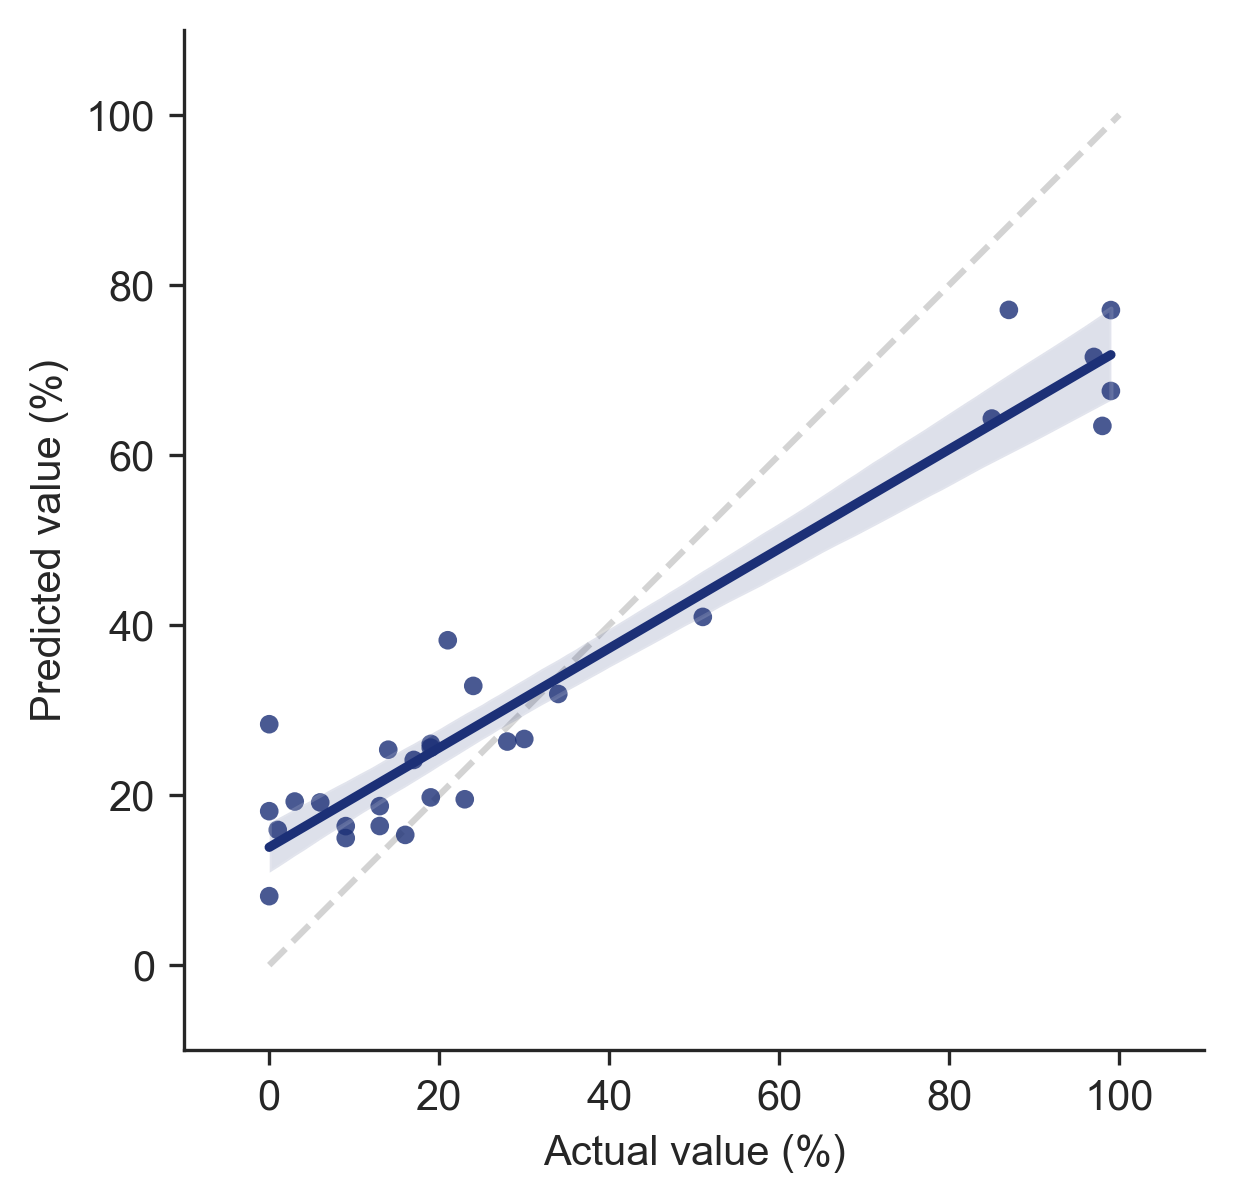

In [20]:
sns.set_style(style='ticks')
color_1 = '#1C3077' # blue
color_2 = '#AED6F1' # light blue
plt.figure(figsize=(5, 5), dpi=300)
# plt.scatter(y_true_all, y_pred_all, s=20, color=color_1, edgecolor="none")
# scatter with error bars on y_pred_all
# plt.scatter(y_true_all, y_pred_all, s=20, color=color_1, edgecolor="none")
ax = sns.lmplot(x='y_true', y='y_pred', data=pd.DataFrame({'y_true':y_true_all, 'y_pred':y_pred_all}), 
                scatter_kws={"s": 20, "color": color_1, "edgecolor": "none"}, 
                line_kws={"color": color_1})
ax.fig.set_dpi(300)
ax.fig.set_size_inches(4, 4)
# plt.errorbar(y_true_all, y_pred_all, yerr=result_all_avg_std['y_pred_std'].values, 
#              fmt='o', color=color_1, ecolor='darkgrey', elinewidth=1, capsize=2, markersize=4)
plt.plot([0, 100], [0, 100], color='lightgrey', linestyle='--', zorder=-1)
# plt.text(0, 90, 'R$^2$ = %.2f \nRMSE = %.2f' % (r2, rmse), fontsize=14)
plt.xlim((-10,110))
plt.ylim((-10,110))
plt.xlabel('Actual value (%)')
plt.ylabel('Predicted value (%)')
sns.despine()
plt.savefig('dataset/'+file_trained+'/scatter_plot_all.pdf', bbox_inches='tight')
